In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Tuple


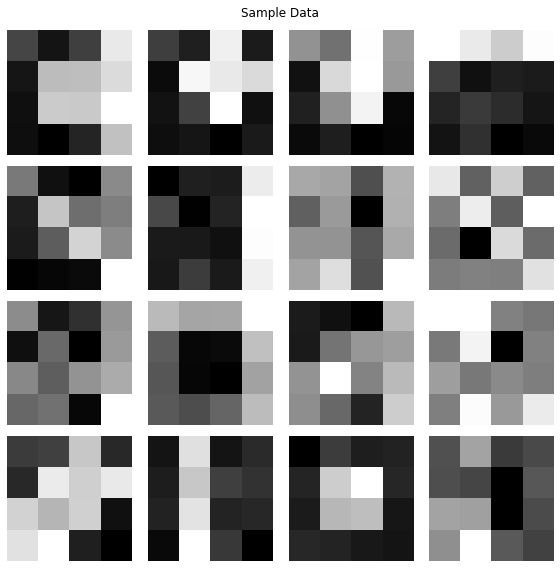

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

# Define latent feature shapes (4x4 images flattened)
features = [
    [0, 0, 1, 0,
     0, 1, 1, 1,
     0, 0, 1, 0,
     0, 0, 0, 0],
    [0, 1, 0, 0,
     0, 1, 0, 0,
     0, 1, 0, 0,
     0, 1, 0, 0],
    [1, 1, 1, 1,
     0, 0, 0, 0,
     0, 0, 0, 0,
     0, 0, 0, 0],
    [1, 0, 0, 0,
     0, 1, 0, 0,
     0, 0, 1, 0,
     0, 0, 0, 1],
    [0, 0, 0, 0,
     0, 0, 0, 0,
     1, 1, 0, 0,
     1, 1, 0, 0],
    [1, 1, 1, 1,
     1, 0, 0, 1,
     1, 0, 0, 1,
     1, 1, 1, 1],
    [0, 0, 0, 0,
     0, 1, 1, 0,
     0, 1, 1, 0,
     0, 0, 0, 0],
    [0, 0, 0, 1,
     0, 0, 0, 1,
     0, 0, 0, 1,
     0, 0, 0, 1],
]

num_samples = 2000  # Number of data points
num_features = 16   # Dimensionality of the data
num_factors = len(features)  # Number of latent factors

# Assign random weights to each feature
feature_weights = 0.5 + np.random.rand(num_factors, 1) * 0.5
mu_transformed = np.array([weight * feature for weight, feature in zip(feature_weights, features)])

# Generate binary latent factors with probability 0.3
latent_factors = np.random.rand(num_samples, num_factors) < 0.3

# Generate data with Gaussian noise
data = latent_factors @ mu_transformed + np.random.randn(num_samples, num_features) * 0.1

# Visualize sample data
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[i].reshape(4, 4), cmap='gray', interpolation='none')
    plt.axis('off')
plt.suptitle("Sample Data")
plt.tight_layout()
plt.show()


In [3]:
class BinaryLatentFactorModel:
    def __init__(self, mu: np.ndarray, sigma: float, pi: np.ndarray):
        """
        Initialize the Binary Latent Factor Model.

        Args:
            mu (np.ndarray): Means of the latent factors (num_features, num_factors).
            sigma (float): Standard deviation of the Gaussian noise.
            pi (np.ndarray): Mixing coefficients (1, num_factors).
        """
        self.mu = mu  # (num_features, num_factors)
        self.sigma = sigma
        self.pi = pi  # (1, num_factors)
        
        
    @property
    def mu(self):
        return self._mu

    @mu.setter
    def mu(self, value):
        self._mu = value
        
    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, value):
        self._sigma = value

    @property
    def variance(self) -> float:
        """Gaussian noise variance."""
        return self.sigma ** 2

    @variance.setter
    def variance(self, value: float) -> None:
        self.sigma = np.sqrt(value)

    @property
    def precision(self) -> float:
        """Precision of the Gaussian noise."""
        return 1 / self.variance

    @property
    def log_pi(self) -> np.ndarray:
        """Log of mixing coefficients."""
        return np.log(self.pi)

    @property
    def log_one_minus_pi(self) -> np.ndarray:
        """Log of one minus mixing coefficients."""
        return np.log(1 - self.pi)

    @property
    def num_features(self) -> int:
        """Number of features."""
        return self.mu.shape[0]

    @property
    def num_factors(self) -> int:
        """Number of latent factors."""
        return self.mu.shape[1]

    def exclude_factor_mu(self, factor_index: int) -> np.ndarray:
        """
        Exclude a specific latent factor from the means.

        Args:
            factor_index (int): Index of the latent factor to exclude.

        Returns:
            np.ndarray: Updated means excluding the specified factor.
        """
        return np.concatenate(
            (self.mu[:, :factor_index], self.mu[:, factor_index + 1:]),
            axis=1,
        )

    @staticmethod
    def m_step(X, ES, ESS):
        """
        mu, sigma, pie = MStep(X,ES,ESS)

        Inputs:
        -----------------
               X: shape (N, D) data matrix
              ES: shape (N, K) E_q[s]
             ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                               if E_q[ss'] is provided, the sum over N is done for you.

        Outputs:
        --------
              mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
           sigma: shape (,)    standard deviation in same
             pie: shape (1, K) vector of parameters specifying generative distribution for s
        """
        N, D = X.shape
        if ES.shape[0] != N:
            raise TypeError('ES must have the same number of rows as X')
        K = ES.shape[1]
        if ESS.shape == (N, K, K):
            ESS = np.sum(ESS, axis=0)
        if ESS.shape != (K, K):
            raise TypeError('ESS must be square and have the same number of columns as ES')

        mu = np.dot(np.dot(np.linalg.inv(ESS), ES.T), X).T
        sigma = np.sqrt((np.trace(np.dot(X.T, X)) + np.trace(np.dot(np.dot(mu.T, mu), ESS))
                         - 2 * np.trace(np.dot(np.dot(ES.T, X), mu))) / (N * D))
        pi = np.mean(ES, axis=0, keepdims=True)

        return mu, sigma, pi

    def maximization_step(self, data: np.ndarray, approximation: 'MeanField') -> None:
        """
        Perform the M-step to update model parameters.

        Args:
            data (np.ndarray): Data matrix (num_samples, num_features).
            approximation (MeanField): Mean field approximation instance.
        """
        mu, sigma, pi = self.m_step(
            data, approximation.expectation_s, approximation.expectation_ss
        )
        self.mu = mu
        self.sigma = sigma
        self.pi = pi


In [4]:
class MeanField:
    def __init__(self, lambda_matrix: np.ndarray, max_steps: int, convergence_threshold: float):
        """
        Initialize the Mean Field Approximation.

        Args:
            lambda_matrix (np.ndarray): Variational parameters (num_samples, num_factors).
            max_steps (int): Maximum number of E-step iterations.
            convergence_threshold (float): Convergence criterion for the E-step.
        """
        self.lambda_matrix = lambda_matrix  # (num_samples, num_factors)
        self.max_steps = max_steps
        self.convergence_threshold = convergence_threshold

    @property
    def expectation_s(self) -> np.ndarray:
        """Expectation of latent factors."""
        return self.lambda_matrix

    @property
    def expectation_ss(self) -> np.ndarray:
        """Expectation of latent factor products."""
        ess = self.lambda_matrix.T @ self.lambda_matrix
        np.fill_diagonal(ess, self.lambda_matrix.sum(axis=0))
        return ess

    @property
    def log_lambda(self) -> np.ndarray:
        """Log of lambda matrix."""
        return np.log(self.lambda_matrix)

    @property
    def log_one_minus_lambda(self) -> np.ndarray:
        """Log of one minus lambda matrix."""
        return np.log(1 - self.lambda_matrix)

    def compute_free_energy(self, data: np.ndarray, model: BinaryLatentFactorModel) -> float:
        """
        Compute the free energy associated with current parameters and data.

        Args:
            data (np.ndarray): Data matrix (num_samples, num_features).
            model (BinaryLatentFactorModel): Binary latent factor model instance.

        Returns:
            float: Average free energy per data sample.
        """
        expectation_log_p_x_s = self._compute_expectation_log_p_x_s(data, model)
        entropy = self._compute_entropy()
        return (expectation_log_p_x_s + entropy) / self.lambda_matrix.shape[0]

    def _compute_expectation_log_p_x_s(self, data: np.ndarray, model: BinaryLatentFactorModel) -> float:
        """
        Compute the expectation of log P(X, S | theta).

        Args:
            data (np.ndarray): Data matrix (num_samples, num_features).
            model (BinaryLatentFactorModel): Binary latent factor model instance.

        Returns:
            float: Expectation of log P(X, S | theta).
        """
        mu_product = self.lambda_matrix @ model.mu.T
        expectation_ss_mu = np.multiply(
            self.lambda_matrix.T @ self.lambda_matrix,
            model.mu.T @ model.mu,
        )

        log_p_x_given_s = (
            -self.lambda_matrix.shape[0] * model.num_features / 2 * np.log(2 * np.pi * model.variance)
            - 0.5 * model.precision
            * (
                np.sum(np.multiply(data, data))
                - 2 * np.sum(data * mu_product)
                + np.sum(expectation_ss_mu)
                - np.trace(expectation_ss_mu)
                + np.sum(
                    self.lambda_matrix @ (model.mu ** 2).T
                )
            )
        )

        log_p_s = np.sum(
            self.lambda_matrix * model.log_pi
            + (1 - self.lambda_matrix) * model.log_one_minus_pi
        )

        return log_p_x_given_s + log_p_s

    def _compute_entropy(self) -> float:
        """
        Compute the entropy of the variational approximation.

        Returns:
            float: Entropy value.
        """
        return -np.sum(
            self.lambda_matrix * self.log_lambda
            + (1 - self.lambda_matrix) * self.log_one_minus_lambda
        )

    def exclude_factor_lambda(self, factor_index: int) -> np.ndarray:
        """
        Exclude a specific latent factor from the lambda matrix.

        Args:
            factor_index (int): Index of the latent factor to exclude.

        Returns:
            np.ndarray: Updated lambda matrix excluding the specified factor.
        """
        return np.concatenate(
            (
                self.lambda_matrix[:, :factor_index],
                self.lambda_matrix[:, factor_index + 1:],
            ),
            axis=1,
        )

    def _partial_e_step(self, data: np.ndarray, model: BinaryLatentFactorModel, factor_index: int) -> np.ndarray:
        """
        Perform a partial variational E-step for a specific latent factor.

        Args:
            data (np.ndarray): Data matrix (num_samples, num_features).
            model (BinaryLatentFactorModel): Binary latent factor model instance.
            factor_index (int): Index of the latent factor to update.

        Returns:
            np.ndarray: Updated lambda vector for the specified latent factor.
        """
        lambda_excluded = self.exclude_factor_lambda(factor_index)
        mu_excluded = model.exclude_factor_mu(factor_index)
        mu_factor = model.mu[:, factor_index]

        log_p_x = (
            model.precision
            * (data - 0.5 * mu_factor.T - lambda_excluded @ mu_excluded.T)
            @ mu_factor
        )

        log_p_s = np.log(model.pi[0, factor_index] / (1 - model.pi[0, factor_index]))

        log_p_total = log_p_x + log_p_s

        lambda_updated = 1 / (1 + np.exp(-log_p_total))
        lambda_updated = np.clip(lambda_updated, 1e-10, 1 - 1e-10)

        return lambda_updated.reshape(-1, 1)

    def variational_e_step(self, data: np.ndarray, model: BinaryLatentFactorModel) -> List[float]:
        """
        Perform the variational E-step.

        Args:
            data (np.ndarray): Data matrix (num_samples, num_features).
            model (BinaryLatentFactorModel): Binary latent factor model instance.

        Returns:
            List[float]: List of free energy values during the E-step iterations.
        """
        free_energy_history = [self.compute_free_energy(data, model)]
        for step in range(self.max_steps):
            for factor in range(model.num_factors):
                self.lambda_matrix[:, factor] = self._partial_e_step(data, model, factor).flatten()
                current_free_energy = self.compute_free_energy(data, model)
                free_energy_history.append(current_free_energy)
                energy_diff = free_energy_history[-1] - free_energy_history[-2]
                if energy_diff <= self.convergence_threshold:
                    break
            if energy_diff <= self.convergence_threshold:
                break
        return free_energy_history


In [5]:
def em_algorithm(
    data: np.ndarray,
    model: BinaryLatentFactorModel,
    approximation: MeanField,
    max_iterations: int = 100
) -> Tuple[MeanField, BinaryLatentFactorModel, List[float]]:
    """
    Perform the EM algorithm to learn binary latent factors.

    Args:
        data (np.ndarray): Data matrix (num_samples, num_features).
        model (BinaryLatentFactorModel): Binary latent factor model instance.
        approximation (MeanField): Mean field approximation instance.
        max_iterations (int): Maximum number of EM iterations.

    Returns:
        Tuple[MeanField, BinaryLatentFactorModel, List[float]]:
            Updated approximation, updated model, and free energy history.
    """
    free_energy_history = [
        approximation.compute_free_energy(data, model)
    ]
    for iteration in range(max_iterations):
        previous_lambda = approximation.lambda_matrix.copy()

        # E-step
        free_energy_history.extend(approximation.variational_e_step(data, model))

        # M-step
        model.maximization_step(data, approximation)

        # Compute free energy
        current_free_energy = approximation.compute_free_energy(data, model)
        free_energy_history.append(current_free_energy)

        # Check for convergence
        energy_diff = abs(free_energy_history[-1] - free_energy_history[-2])
        lambda_diff = np.linalg.norm(approximation.lambda_matrix - previous_lambda)
        if energy_diff == 0 and lambda_diff == 0:
            print(f"Converged at iteration {iteration + 1}")
            break
    return approximation, model, free_energy_history


In [31]:
def visualize_latent_features(mu: np.ndarray, num_factors: int, title: str, save_path: str) -> None:
    """
    Visualize latent features as 4x4 images.

    Args:
        mu (np.ndarray): Means of the latent factors (num_features, num_factors).
        num_factors (int): Number of latent factors.
        title (str): Title of the plot.
        save_path (str): Path to save the figure.
    """
    fig, axes = plt.subplots(1, num_factors, figsize=(num_factors * 2, 2))
    for i in range(num_factors):
        axes[i].imshow(mu[:, i].reshape(4, 4), cmap='gray', interpolation='none')
        axes[i].set_title(f"Feature {i+1}")
        axes[i].axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def plot_free_energy(free_energy: List[float], title: str, save_path: str) -> None:
    """
    Plot the free energy over EM iterations.

    Args:
        free_energy (List[float]): Free energy history.
        title (str): Title of the plot.
        save_path (str): Path to save the figure.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(free_energy, marker='o')
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Free Energy")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


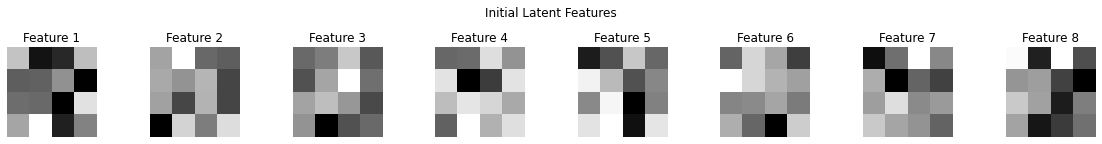

Converged at iteration 86


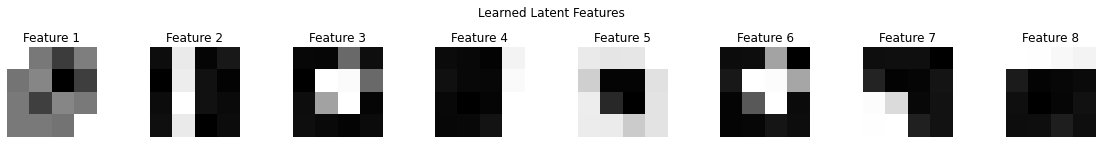

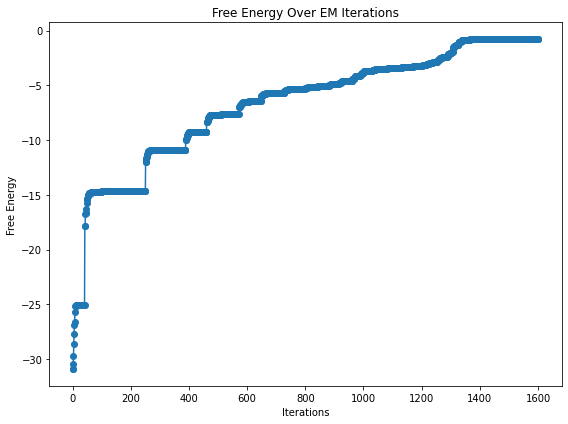

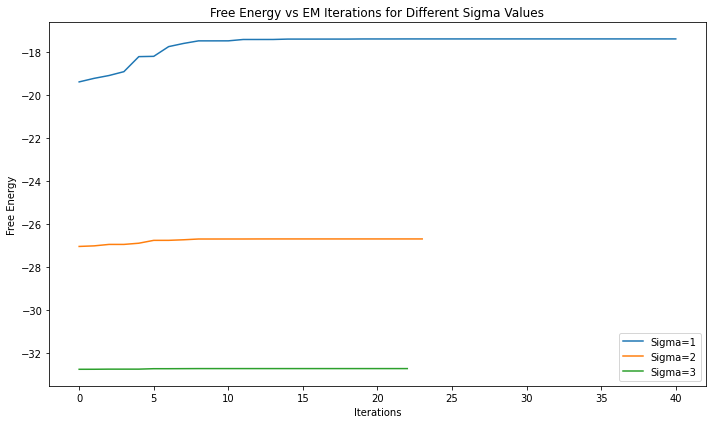

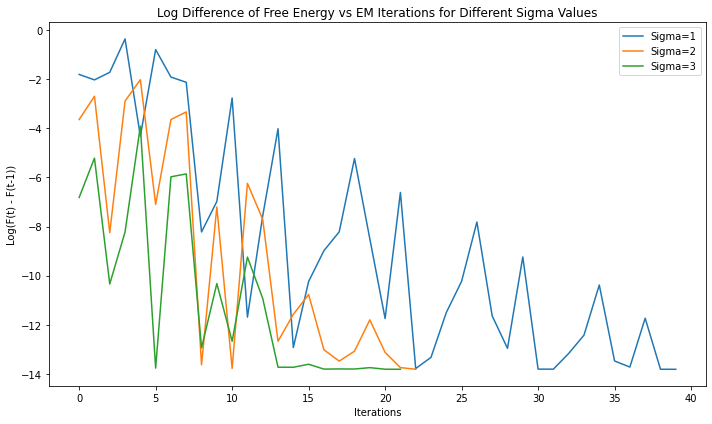

Results saved in '.' directory.


In [59]:
def main():
    # Prepare output directories
    outputs_dir = "."
    os.makedirs(outputs_dir, exist_ok=True)

    # Initialize model parameters using Kaiming initialization
    initial_sigma = 1.0
    initial_pi = np.full((1, num_factors), 0.5)

    # Kaiming initialization for mu
    initial_mu = np.random.randn(num_features, num_factors) * np.sqrt(2 / num_features)

    # Create model and approximation instances
    model = BinaryLatentFactorModel(mu=initial_mu, sigma=initial_sigma, pi=initial_pi)
    initial_lambda = np.random.rand(num_samples, num_factors)
    approximation = MeanField(
        lambda_matrix=initial_lambda,
        max_steps=100,
        convergence_threshold=1e-9
    )

    # Visualize initial latent features
    visualize_latent_features(
        mu=model.mu,
        num_factors=num_factors,
        title="Initial Latent Features",
        save_path=os.path.join(outputs_dir, "3f1.png")
    )

    # Perform EM algorithm
    approximation, model, free_energy = em_algorithm(
        data=data,
        model=model,
        approximation=approximation,
        max_iterations=1000
    )

    # Visualize learned latent features
    visualize_latent_features(
        mu=model.mu,
        num_factors=num_factors,
        title="Learned Latent Features",
        save_path=os.path.join(outputs_dir, "3f2.png")
    )

    # Plot free energy progression
    plot_free_energy(
        free_energy=free_energy,
        title="Free Energy Over EM Iterations",
        save_path=os.path.join(outputs_dir, "3e1.png")
    )

    # Analyze free energy with different sigma values
    sigmas = [1, 2, 3]
    free_energies_sigma = []
    for sigma in sigmas:

        temp_data = data[:1, :]
        model.sigma = sigma
      
        temp_approximation = MeanField(
            lambda_matrix=approximation.lambda_matrix[:1, :],
            max_steps=approximation.max_steps,
            convergence_threshold=approximation.convergence_threshold,
        )
        fe = temp_approximation.variational_e_step(
            data=temp_data,  
            model=model
        )
        free_energies_sigma.append(fe)

    # Plot free energy for different sigma values
    plt.figure(figsize=(10, 6))
    for idx, fe in enumerate(free_energies_sigma):
        plt.plot(fe, label=f"Sigma={sigmas[idx]}")
    plt.title("Free Energy vs EM Iterations for Different Sigma Values")
    plt.xlabel("Iterations")
    plt.ylabel("Free Energy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_dir, "3g1.png"), bbox_inches="tight")
    plt.show()

    # Plot log differences of free energy for different sigma values
    plt.figure(figsize=(10, 6))
    for idx, fe in enumerate(free_energies_sigma):
        diffs = np.diff(fe)
        log_diffs = np.log(diffs + 1e-6)
        plt.plot(log_diffs, label=f"Sigma={sigmas[idx]}")
    plt.title("Log Difference of Free Energy vs EM Iterations for Different Sigma Values")
    plt.xlabel("Iterations")
    plt.ylabel("Log(F(t) - F(t-1))")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_dir, "3g2.png"), bbox_inches="tight")
    plt.show()

    print(f"Results saved in '{outputs_dir}' directory.")

if __name__ == "__main__":
    main()
